In [1]:
import pandas as pd
import os
import numpy as np 
from tqdm import tqdm
import shutil
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv

## Location of Dataset

In [12]:
#Take data folder location as input
src_dir = input("Enter location to Data Folder : ")

if os.path.exists(src_dir):
    dir_ = os.listdir(src_dir)
    print(f"Data Folder : {dir_}")

Enter location to Data Folder : ./../data/devanagari/trainset/
Data Folder : ['images', '.DS_Store', 'labels.json', 'unique_words.txt', 'vocab.txt', 'train.txt']


## Get data as frame

In [13]:
#Find test.txt, train.txt, val.txt and load them as pandas frame

train_index = dir_.index('train.txt')
test_index = dir_.index('test.txt')
val_index = dir_.index('val.txt')

#Location
train_txt = os.path.join(src_dir, dir_[train_index])
test_txt = os.path.join(src_dir, dir_[test_index])
val_txt = os.path.join(src_dir, dir_[val_index])
# print(val_txt_loc)

train_df = pd.read_csv(train_txt, sep=" ", header=None, names=["files", "tokens"])
test_df = pd.read_csv(test_txt, sep=" ", header=None, names=["files", "tokens"])
val_df = pd.read_csv(val_txt, sep=" ", header=None, names=["files", "tokens"])

ValueError: 'test.txt' is not in list

In [814]:
# train_df.sort_values("files", inplace=True)
# train_df.sort_values("files")
train_df.head ()

,files,tokens
0,HindiSeg/train/8/251/21.jpg,केंद्रों
1,HindiSeg/train/10/207/8.jpg,पॉवर
2,HindiSeg/train/10/31/19.jpg,तरक्की
3,HindiSeg/train/5/246/23.jpg,मजा
4,HindiSeg/train/8/266/25.jpg,मांजने


## Destination Directory

In [797]:
#Take dest folder as input
dest_dir = input("Enter location for Data Folder : ")

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

print(f"Destination folder: {dest_dir}")

Enter location for Data Folder : ../data/trainset
Destination folder: ../data/trainset


## Make data set

## Pre Processing

Before feeding an image to a CRNN (Convolutional Recurrent Neural Network) for text recognition, there are several preprocessing steps that can be performed to improve the accuracy of the OCR (Optical Character Recognition) system. Some of the common preprocessing steps are:

* Image resizing and normalization: The input image can be resized to a fixed height while maintaining the aspect ratio, and then normalized to have zero mean and unit variance. This helps in reducing the computational complexity and also normalizes the image intensity values.

* Image binarization: The input image can be converted to a binary image, where pixels with intensity values above a threshold are set to white and others are set to black. This step helps in removing noise and enhancing the contrast between the text and the background.

* Skew correction: If the input image is tilted or skewed, it can be corrected to be horizontally aligned. This can be done using algorithms such as Hough Transform, which detect the dominant lines in the image and rotate the image to align them with the horizontal axis.

* Noise removal: The input image can be filtered using techniques such as median filtering or Gaussian blurring to remove noise and smoothen the image.

* Text localization: The input image can be segmented to locate the regions containing text using techniques such as thresholding, edge detection, or connected component analysis.

* Data augmentation: To increase the size of the training data and improve the robustness of the OCR system, the input images can be augmented by applying random transformations such as rotation, translation, scaling, and shearing.

## Hough Transfrom : 
* Technique used to detect geometric shapes in an image, such as lines, circles, and ellipses

* Transform works by converting the image space into a parameter space, where the geometric shapes can be represented as mathematical equations with specific parameters

* For each edge point in the image, a set of possible lines that pass through that point in the parameter space is generated. The accumulator array is then updated to increment the count for each possible line that passes through that point.

Note:

* We calculate the median angle instead of the mean angle to reduce the impact of outliers or noise in the detected lines. Median is less sensitive to extreme values, which makes it a more robust measure for central tendency in situations where the data might not be normally distributed or may contain extreme values.

* Resizing the image after skew correction may result in distorted content, especially if the aspect ratio changes significantly after skew correction. Furthermore, resizing may introduce artifacts or cause the loss of details in the image.

In [867]:
def skewCorrection(img, SKEW_RESULTS=True):
    """
    img : Grey/Binary image
    HOUHG_RESULTS : For displaying hough transform results
    """
    #Hough Transform
    
    # Perform edge detection using the Canny algorithm
    edges = cv.Canny(img, 50, 150, apertureSize=3)
    
    # Apply the Hough Transform to detect lines
    # The second and third arguments are the rho and theta resolutions
    # The fourth argument is the threshold for line detection
    lines = cv.HoughLines(edges, 1, np.pi / 180, 50)
    
    
    #Skew correction
    
    #calculate the avg angle of the detected lines
    try:
        angles = []
        for line in lines:
            rho, theta = line[0]
            angle = (theta * 180)/np.pi
            angles.append(angle)

        # Calculate the median angle and correct the skew
        median_angle = np.median(angles)
        # Subtract 90 to obtain the skew angle
        rotation_angle = median_angle - 90

        #Center of image
        height, width = img.shape[:2]
        center = (width//2, height//2)

        # Rotate the original image using the calculated angle
        rotation_matrix = cv.getRotationMatrix2D(center, rotation_angle, 1)
        rotated_img = cv.warpAffine(img, rotation_matrix, (width, height), borderValue=(255, 255, 255))
    except TypeError:
        rotated_img = img

    
    if (SKEW_RESULTS):
        print(f"No. of lines Detected: {lines.shape[0]}")

        # Draw the detected median lines on the original image
        
        # Find the index of the angle closest to the median_angle
        closest_angle_index = np.argmin(np.abs(np.array(angles) - median_angle))

        # Retrieve the corresponding rho and theta values
        rho, theta = lines[closest_angle_index][0]
        
        # For convreting polar co-ordinates to cartesian co-ordinates
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        # pts in perpendicular direction of the reference pt(x0,y0) for making a line segment
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        
        plt.figure(figsize=(20,10))
        plt.subplot(2,2,1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")

        plt.subplot(2,2,2)
        plt.imshow(edges, cmap="gray")
        plt.title("Canny Edges")
        plt.axis("off")
        plt.show()
        
        plt.subplot(2,2,3)
        plt.imshow(rotated_img, cmap="gray")
        plt.title("Unskewed Image", fontsize=8)
        plt.axis("off")
        plt.show()
        
    return rotated_img

### Generator :
* A generator function, maintains its internal state between calls. 

* Instead of processing all the elements at once and returning the results, a generator function yields results one at a time using the yield keyword. When the generator function is called, it executes until it encounters a yield statement, then it pauses its execution and returns the yielded value. 

* The function's internal state (including local variables, the current position in the loop, etc.) is maintained so that when the generator is called again, it resumes execution right after the yield statement.

In [863]:
def imagePre(img_locs):
    
    for loc in img_locs:
    
        #Load the image
        img = cv.imread(loc)

        #Greyscale 
        grey_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        #No resizing(Already taken care by doctr apparently :/)

        # Apply thresholding to convert the image to binary
        #returns threshold val and binary image
        binary_img = cv.threshold(grey_img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]

        #erosion operation is typically used to fill small gaps in the objects, 
        kernel = cv.getStructuringElement(cv.MORPH_RECT, (5,5))
        erosion = cv.erode(binary_img, kernel, iterations = 1)


        unskewed_img = skewCorrection(erosion, False)


        #Standardize the image
#         mean = np.mean(unskewed_img)
#         std = np.std(unskewed_img)

#         std_img = (unskewed_img - mean)/std

        yield unskewed_img

### Skew Corrected Images(GreyScale)

No. of lines Detected: 7


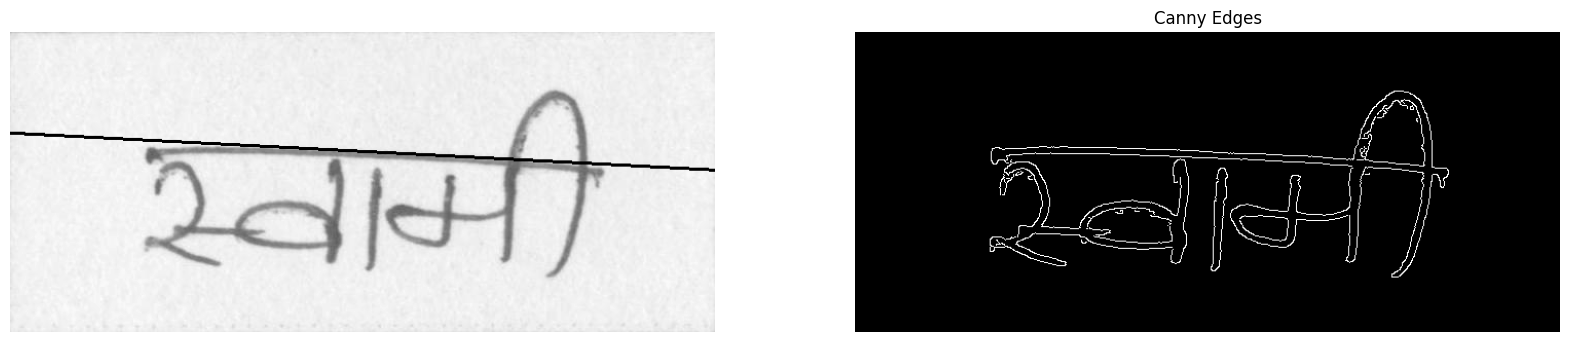

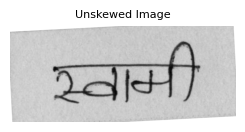

In [778]:
grey_img = cv.imread(img_locs[14], cv.IMREAD_GRAYSCALE)
unkewed_img = skewCorrection(grey_img)

### Skew Corrected Images(Binary)

In [837]:
slice_df = train_df.loc[0:100, "files"]
img_locs = list(slice_df)

img_locs = [os.path.join(src_dir, loc) for loc in img_locs]

# img_locs = img_locs[0]
# print(img_locs)

img_gen = imagePre(img_locs)

In [850]:
std_img = next(img_gen)

Mean : 1.564070048290614e-16 
Std : 0.9999999999999994


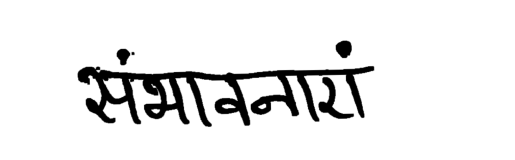

In [851]:
print(f"Mean : {np.mean(std_img)} \nStd : { np.std(std_img)}")
plt.imshow(std_img, cmap="gray")
plt.axis("off")
plt.show()

In [868]:
#Take these files and rename them and store them into another file
from itertools import islice


def make_dataset(src_dir, df, dest_dir="../data/trainset", no_of_examples=None):
    
    if no_of_examples == None:
        no_of_examples=len(df["files"])

    img_folder = os.path.join(dest_dir, "images")
    if not os.path.exists(img_folder):
        os.makedirs(img_folder)

    values = {}
    count = 1
    for index, row in tqdm(islice(df.iterrows(), no_of_examples), total = no_of_examples, desc = "Progress"):
        img_loc = os.path.join(src_dir, row["files"])
        
        std_img = next(imagePre([img_loc]))
        

        #New filename
        new_filename = f"img_{count}.jpg"

        new_img_loc = os.path.join(img_folder, new_filename)
    
        #Copying all the files to training set
#         shutil.copy(img_loc, new_img_loc)

        # saving all the pre processed image to training set
        cv.imwrite(new_img_loc, std_img)

        values[new_filename] = row["tokens"]
        count += 1
        
        #Making json file
        json_filename = "labels.json"

        json_loc = os.path.join(dest_dir, json_filename)

        with open(json_loc, "w", encoding='utf-8') as f:
            json.dump(values, f, ensure_ascii=False, indent=4)


In [869]:
#Making Training Dataset
make_dataset(src_dir=src_dir, dest_dir=dest_dir, df=train_df)

Progress: 100%|████████████████████████████████| 69853/69853 [1:11:53<00:00, 16.19it/s]


In [26]:
#Making validation Dataset
make_dataset(src_dir=src_dir, dest_dir=dest_dir, df=val_df, no_of_examples=1000)

Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 417.86it/s]
